In [2]:
#Import 
import warnings; warnings.simplefilter('ignore') #for PCoA warnings
import pandas as pd
import numpy as np
import random
import itertools
#plotting
import seaborn as sns
import matplotlib.pyplot as plt
#MOCK data generation
from gneiss import util
#biplots
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralBiclustering
#from sklearn.metrics import consensus_score
from sklearn.utils import shuffle
#DEICODE
from DEICODE.untangle import complete_matrix,machine_learning,biplot
#transforms 
from skbio.stats.composition import clr,ilr
# Intials
rand = np.random.RandomState(42)
fnts=12
%matplotlib inline
# make the notebook readable
from IPython.core.display import HTML
HTML("""<style>div.cell { /* Tunes the space between cells */margin-top:1em;margin-bottom:1em;}div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 3em;line-height:1.4em;text-align:center;}
div.text_cell_render h2 { /*  Parts names nearer from text */margin-bottom: -0.4em;}
div.text_cell_render { /* Customize text cells */font-family: 'Times New Roman';font-size:1.5em;line-height:1.4em;
padding-left:3em;padding-right:3em;}</style>""")


For 16S rRNA gene amplicon studies the data set used is a table with operational taxonomic unit (OTU) information for each sample (e.g. biom table). The metadata labels for each sample is recovered from the associated mapping file. A common goal is to relate the OTU composition for each sample to appropriate environmental factors or patient data categories. 

In OTU tables the underlying ecological patterns can often be lost by noise, this is the main problem that DEICODE tries to address.

Noise in 16S rRNA gene amplicon studies comes from many sources but two main factors are addressed here. 

1. Low biomass sampling and imperfect sampling which causes many zeros in the OTU table and low-signal strength.

2. Heteroscedastic noise where the level of noise varies from measurement to measurement that can come from many biological factors. One example is technical variation or inherent experimental contamination.

        
These problems can be solved by Matrix Completion.

    Matrix completion is a method where unknown values can be approximated using the known data. This recovers data that has low-density heteroscedastic noise.
    
<img src="etc/decomp.png">

This solution has two main benefits 

1. machine learning can be applied to the recovered underlying ecological patterns
2. spectral biclustering relate ecology directly to ordination 

Now we will demonstrate how these problems can be solved

Matrix Completion will allow machine learning to be applied to the recovered underlying ecological patterns.

To demonstrate this we will generate a simulated OTU table and then we will introduce noise into the data. To do this let's write a convent routine to introduce noise to our simulated OTU table. 

In [3]:
def add_noise(X_true,hoced=0.0002,hsced=0.001,inten=.0001,spar=10):
    
    # add noise
    # 1:Homoscedastic noise (noise levels do not vary from measurement to measurement)
    # 2:Heteroscedastic noise (noise levels do vary from measurement to measurement)
    # 3: Low-density (coherce random values to zero)
    
    # add Homoscedastic noise
    err = hoced * np.ones_like(X_true.as_matrix().copy())
    X_noise = rand.normal(X_true.as_matrix().copy(), err)
    # add Heteroscedastic noise
    err = hsced * np.ones_like(X_noise)
    i = rand.randint(0, err.shape[0], 5000)
    j = rand.randint(0, err.shape[1], 5000)
    err[i, j] = inten
    X_noise = abs(rand.normal(X_noise, err))
    # Induce low-density into the matrix
    mask = np.random.randint(0,spar,size=X_noise.shape).astype(np.bool)
    rand_zeros = np.random.rand(*X_noise.shape)*0
    X_noise[mask] = rand_zeros[mask]
    #return the noisy data 
    return pd.DataFrame(X_noise,columns=X_true.columns,index=X_true.index)     

Next we can simulate a simple case where there are only two niches, this could represent two environments sampled, for example healthy and sick samples.

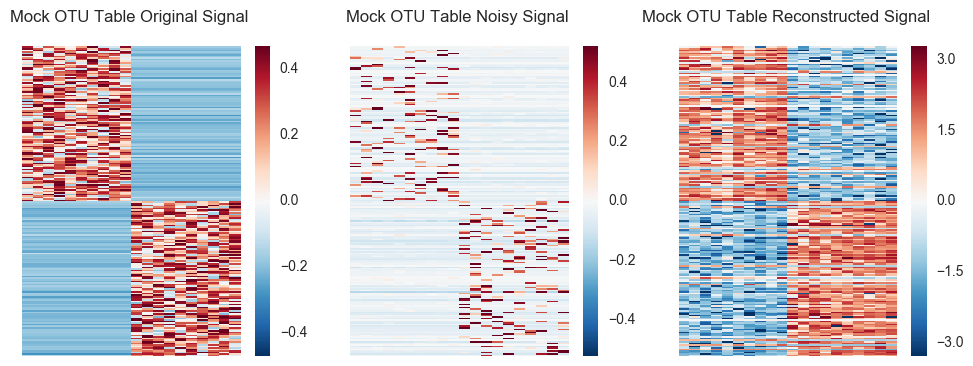

In [4]:
r=2 #numbers of blocks (rank of the matrix)
n=r*10 # number of columns (Samples)
b=n*10 # number of rows (OTUS)

# make a mock OTU table
X_true=pd.DataFrame(util.block_diagonal(n,b,r),columns=['sample_'+str(x) for x in range(0,n)],index=['OTU_'+str(x) for x in range(0,(b))]) 

# add noise
# now we add noise, we will add three types of noise: 
# 1:Homoscedastic noise (noise levels do not vary from measurement to measurement)
# 2:Heteroscedastic noise (noise levels do vary from measurement to measurement)
# 3: Low-density (coherce random values to zero)

X_noise=add_noise(X_true.copy(),.02,.01,.01,5)

#recover 
X_recovered=complete_matrix(X_noise.as_matrix().copy(),iteration=300,minval=1e-3)

#visualize 
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12, 4),sharey=False)
sns.heatmap(clr(X_true+1),xticklabels=False, yticklabels=False,robust=True,ax=ax1)
ax1.set_title('Mock OTU Table Original Signal \n',fontsize=fnts)
sns.heatmap(clr(X_noise+1),xticklabels=False, yticklabels=False,robust=True,ax=ax2)
ax2.set_title('Mock OTU Table Noisy Signal \n',fontsize=fnts)
sns.heatmap(clr(X_recovered),xticklabels=False, yticklabels=False,robust=True,ax=ax3)
ax3.set_title('Mock OTU Table Reconstructed Signal \n',fontsize=fnts)
plt.show()

As you can see above, the original signal can be mostly recovered from the noise using matrix completion. 

Random Forests is a form of supervised machine learning. Supervised machine learning is a method for developing predictive models from training data sets. This can reveal complex pattens in data associated with biologically important metadata such as disease states or environmental factors. 

For 16S rRNA gene amplicon studies the training data set used an OTU table (e.g. biom table). The metadata labels for each sample is recovered from the associated mapping file. This allows you to assign each sample into the appropriate environmental factor or patient data category.  

OTU tables contain low-density heteroscedastic noise and are difficult for supervised machine learning alogrithims to accurately predict. To overcome this problem we use matrix completion.
    
Cross-validation is done through taking a portion of the data (usually 80%) and predicting the remaining data (i.e. 20%). The score is the accuracy between the predicted data and the remaining data. The cross-validation score essentially tells you how accurate your supervised machine learning model is. 


#### To demonstrate how matrix completion can be uses for machine learning we will check the mean cross-validation score (mean of ten iterations) from 2 niches to 40 niches.  

In [5]:
#test machine learning 
lw=[]
nr=[]
rnagstart=2 #must be larger than two but less than rnagend
rnagend=41 # number of niches to check 
save_heat=[] # to visualize the otu table and certain points
save_heat_org=[]
save_heat_noisy=[]
for under_rank in range(rnagstart,rnagend):

    ### generate data ### 
    r=under_rank #numbers of blocks (rank of the matrix)
    n=r*10 # number of columns (Samples)
    b=n*10 # number of rows (OTUS)
    # make a mock mapping data
    mapping=pd.DataFrame(np.array([['Niche %s'%str(x)]*int(n/r) for x in range(1,r+1)]).flatten(),columns=['example'],index=['sample_'+str(x) for x in range(0,n)])
    
    # make a mock OTU table
    X_true=pd.DataFrame(util.block_diagonal(n,b,r),columns=['sample_'+str(x) for x in range(0,n)],index=['OTU_'+str(x) for x in range(0,(b))]) 
    
    # add noise 
    X_noise=add_noise(X_true,0.02,0.09,.1,8)
    
    #save a few of them to view what it looks like
    if under_rank==rnagstart or under_rank==(rnagend-1)/2  or under_rank==(rnagend-1) :
        save_heat_org.append(X_true)
        save_heat_noisy.append(X_noise)
        
    #run machine learning 
    cross_valscores_lw,low_rank_data=machine_learning(X_noise,mapping,complete=True,iteration=100,mean_count=10)   
    lw.append(cross_valscores_lw.values[0][0])
    cross_valscores,low_rank_data=machine_learning(X_noise,mapping,complete=False,mean_count=10)   
    nr.append(cross_valscores.values[0][0])
    

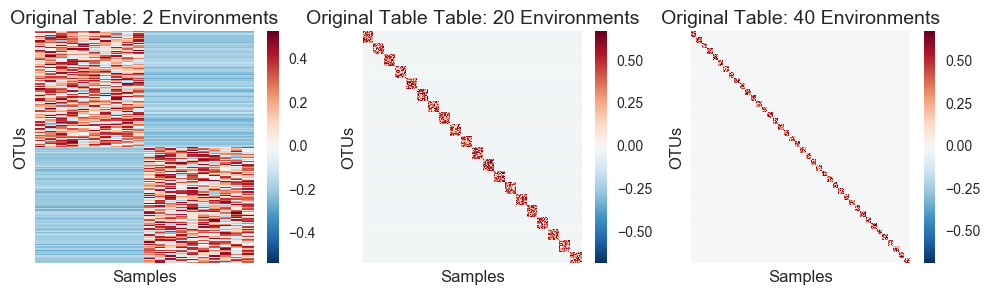

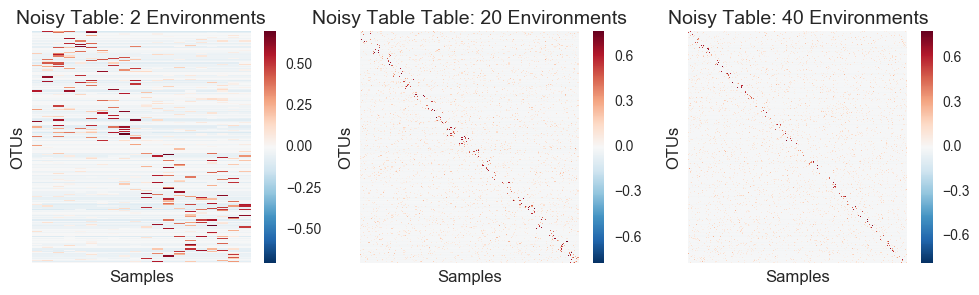

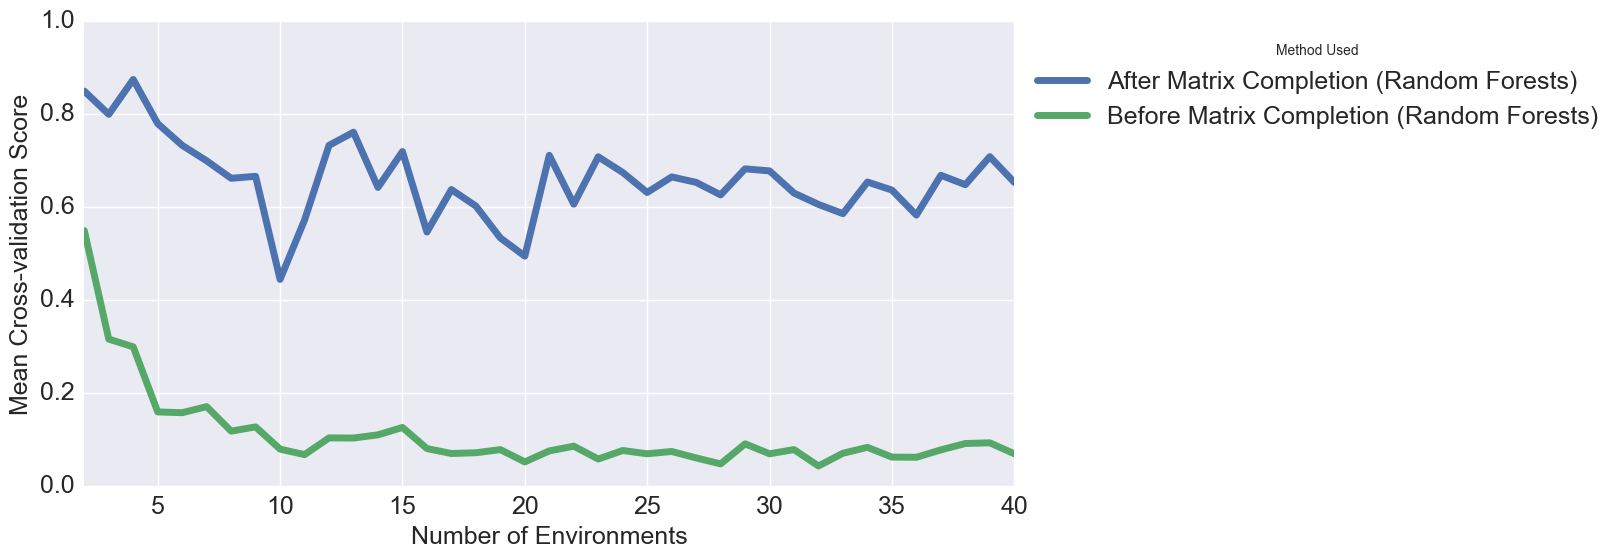

In [12]:
scores=pd.DataFrame({'After Matrix Completion (Random Forests)': lw,'Before Matrix Completion (Random Forests)': nr,},index=list(range(rnagstart,rnagend)))     

#plot a few heatmaps
fig_fontsize=14
for save_heat,b4 in zip([save_heat_org,save_heat_noisy],['Original Table','Noisy Table']):
    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12, 3),sharey=False)
    sns.heatmap(clr(save_heat[0]+1),xticklabels=False, yticklabels=False,ax=ax1)
    ax1.set_title('%s: %i Environments'%(b4,int(rnagstart)),fontsize=fig_fontsize)
    ax1.set_ylabel('OTUs',fontsize=fig_fontsize-2)
    ax1.set_xlabel('Samples',fontsize=fig_fontsize-2)
    sns.heatmap(clr(save_heat[1]+1),xticklabels=False, yticklabels=False,ax=ax2)
    ax2.set_title('%s Table: %i Environments'%(b4,int((rnagend-1)/2)),fontsize=fig_fontsize)
    ax2.set_ylabel('OTUs',fontsize=fig_fontsize-2)
    ax2.set_xlabel('Samples',fontsize=fig_fontsize-2)
    sns.heatmap(clr(save_heat[2]+1),xticklabels=False, yticklabels=False,ax=ax3)
    ax3.set_title('%s: %i Environments'%(b4,int(rnagend-1)),fontsize=fig_fontsize)
    ax3.set_ylabel('OTUs',fontsize=fig_fontsize-2)
    ax3.set_xlabel('Samples',fontsize=fig_fontsize-2)
    plt.show()

#plot machine leanring scores 
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(12, 6),sharey=True)
scores.plot(ylim=(0,1),lw=5,ax=ax1,fontsize=18)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels,loc=2,prop={'size':18}, bbox_to_anchor=(1.0, 1.0),title='Method Used')
ax1.set_xlabel('Number of Environments',fontsize=18)
ax1.set_ylabel('Mean Cross-validation Score',fontsize=18)
plt.show()

In [68]:
#lets see what the avrage improvement over all of the niches is
np.mean(lw)-np.mean(nr)



0.53935853298926451

Now we can see that the cross-validation scores are significantly increased in the recovered OTU table by matrix completion. This means the machine learning is able to locate the patterns much more clearly in reconstructed data. We increased the cross-validation score by .53 on average.  

### Biclustering

Biclustering is a method where we can take shuffled seemingly random data and rearrange it into a groups that make sense. 

<img src="etc/biclustering.jpeg">

This can allow us to identify the differential community members between sample groups.


To demonstrate this we test a mock OTU table with 2 niches and then an OTU table with equal number of niches to samples. 

To make it easy to visualize we will use a simple plotting routine

In [58]:
# we will use this as our simple plotting function
def plot_compare(otupcoadf,otudata,mapping,catvis,r,titleadd='',hmax=6,fig_fontsize=18,isorg=True):
        
    #first we will take the bicluser 
    biploto,datatmp=biplot(otudata,r)
    
    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12, 5)) 

    if titleadd!='':
        fig.suptitle('%s '%(titleadd),fontsize=fig_fontsize+4)

    sns.heatmap(otudata,xticklabels=False, yticklabels=False,robust=True,ax=ax1)
    ax1.set_title('OTU Table\n',fontsize=fig_fontsize)    
    ax1.set_ylabel('OTUs',fontsize=fig_fontsize-2)
    ax1.set_xlabel('Samples',fontsize=fig_fontsize-2)

    sns.heatmap(biploto,xticklabels=False, yticklabels=False,robust=True,ax=ax2)
    ax2.set_title('Spectral Coclustering \n',fontsize=fig_fontsize)    
    ax2.set_ylabel('OTUs',fontsize=fig_fontsize-2)
    ax2.set_xlabel('Samples',fontsize=fig_fontsize-2)
    
    pcaplot=pcoa(DistanceMatrix(pdist(otupcoadf.as_matrix().T,'braycurtis'),list(otupcoadf.columns))).samples[['PC1','PC2','PC3']]
    pcaplot[catvis]=list(mapping.T[catvis])
    for ((key, grp)) in pcaplot.groupby(catvis):
        ax3.scatter(grp['PC1'], grp['PC2'], color=next(ax1._get_lines.prop_cycler)['color'], label=key, s=50)
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.legend(loc=2,prop={'size':16},bbox_to_anchor=(1.0, 1.0))
    ax3.set_title('PCoA (bray-curtis) \n',fontsize=fig_fontsize)
    ax3.set_ylabel('$PC-1$',fontsize=fig_fontsize-2)
    ax3.set_xlabel('$PC-2$',fontsize=fig_fontsize-2)   

    plt.tight_layout()
    fig.subplots_adjust(top=.78)

    return 

First we will use the mock data where there is two clear niches, this could be something like sick and healthy. 

In [60]:
### generate data ### 
r=2 #numbers of blocks (rank of the matrix)
n=r*30 # number of columns (Samples)
b=n*10 # number of rows (OTUS)
# make a mock mapping data
mapping=pd.DataFrame(np.array([['Environment %s'%str(x)]*int(n/r) for x in range(1,r+1)]).flatten(),columns=['example'],index=['sample_'+str(x) for x in range(0,n)])
# make a mock OTU table
X_true=pd.DataFrame(util.block_diagonal(n,b,r),columns=['sample_'+str(x) for x in range(0,n)],index=['OTU_'+str(x) for x in range(0,(b))])
#get shuffled noise
X_noise_suffle, row_idx, col_idx = sg._shuffle(add_noise(X_true,.01,.01,.04,22).as_matrix(), random_state=0)
#run matrix completion
reconstuctdf=complete_matrix(X_noise_suffle.copy(),iteration=100,minval=1e-3)

#make dataframes
X_noise_suffle=pd.DataFrame(clr(X_noise_suffle+1),columns=X_true.columns,index=X_true.index)
reconstuctdf=pd.DataFrame(clr(reconstuctdf),columns=X_true.columns,index=X_true.index)

 Now we will use our plotting function to visualize the PCA, PCoA and clr-PCA (scatter plots left to right) on reconstructed data for the OTU table before (top) and after we add noise (bottom). 

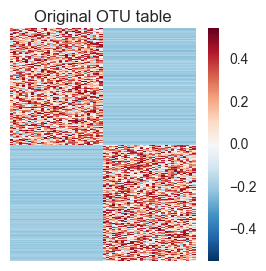

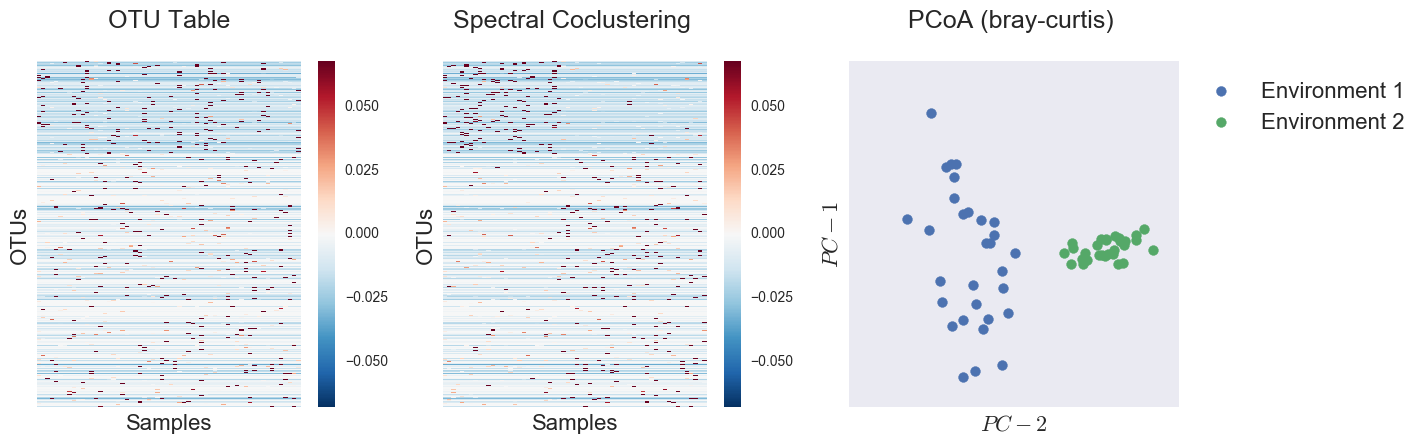

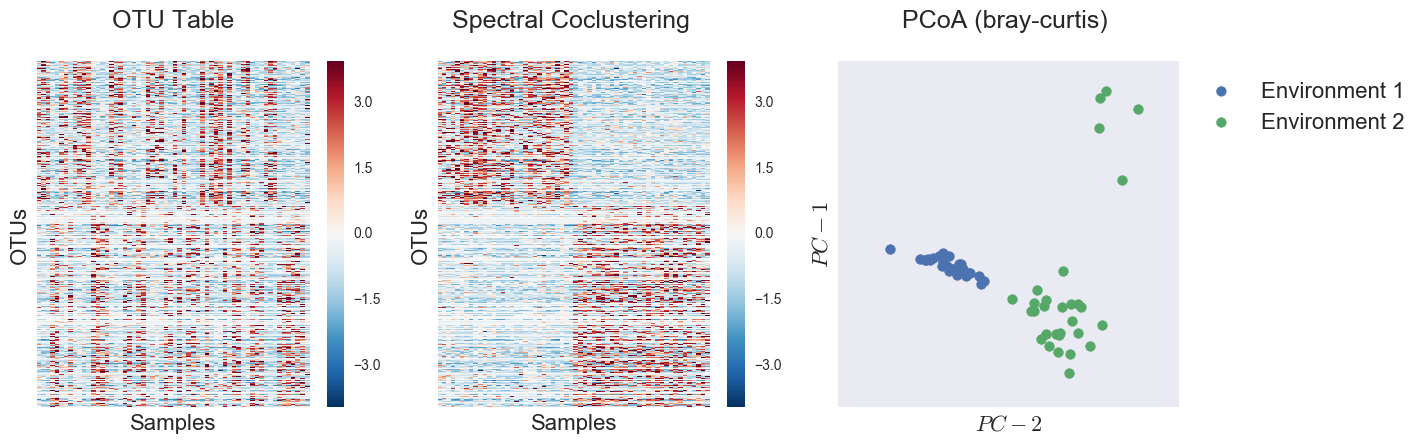

In [61]:
#show ground truth
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(3, 3)) 
sns.heatmap(clr(X_true+1),xticklabels=False, yticklabels=False,ax=ax1)
ax1.set_title('Original OTU table')
#comparison
#orgigonal
plot_compare(add_noise(X_true,.01,.01,.04,22),X_noise_suffle,mapping.T,'example',2)
#completed
plot_compare(add_noise(X_true,.01,.01,.04,22),reconstuctdf,mapping.T,'example',2)

Now we can try this with a more complicated sample

In [63]:
### generate data ### 
r=4 #numbers of blocks (rank of the matrix)
n=r*10 # number of columns (Samples)
b=n*10 # number of rows (OTUS)
minvalues=[1e-50,1] #minimum values for matrix completion (must be >0 for clr transoform)
iterations=[100,300] #number of iterations for matrix completion 
# make a mock mapping data
mapping=pd.DataFrame(np.array([['Niche %s'%str(x)]*int(n/r) for x in range(1,r+1)]).flatten(),columns=['example'],index=['sample_'+str(x) for x in range(0,n)])
# make a mock OTU table
X_true=pd.DataFrame(util.block_diagonal(n,b,r),columns=['sample_'+str(x) for x in range(0,n)],index=['OTU_'+str(x) for x in range(0,(b))]) 


#get shuffled noise
X_noise_suffle, row_idx, col_idx = sg._shuffle(add_noise(X_true,.01,.01,.02,4.9).as_matrix(), random_state=0)
#run matrix completion
reconstuctdf=complete_matrix(X_noise_suffle.copy(),iteration=100,minval=1e-3)

#make dataframes
X_noise_suffle=pd.DataFrame(clr(X_noise_suffle+1),columns=X_true.columns,index=X_true.index)
reconstuctdf=pd.DataFrame(clr(reconstuctdf),columns=X_true.columns,index=X_true.index)

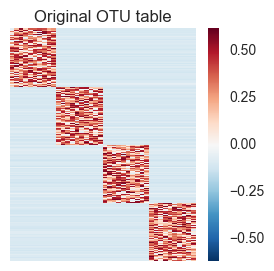

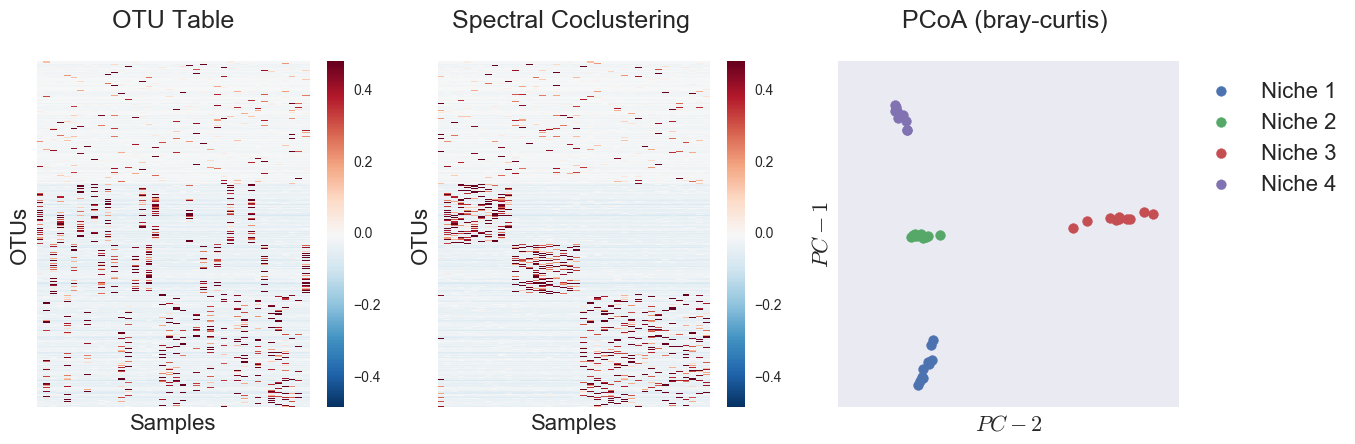

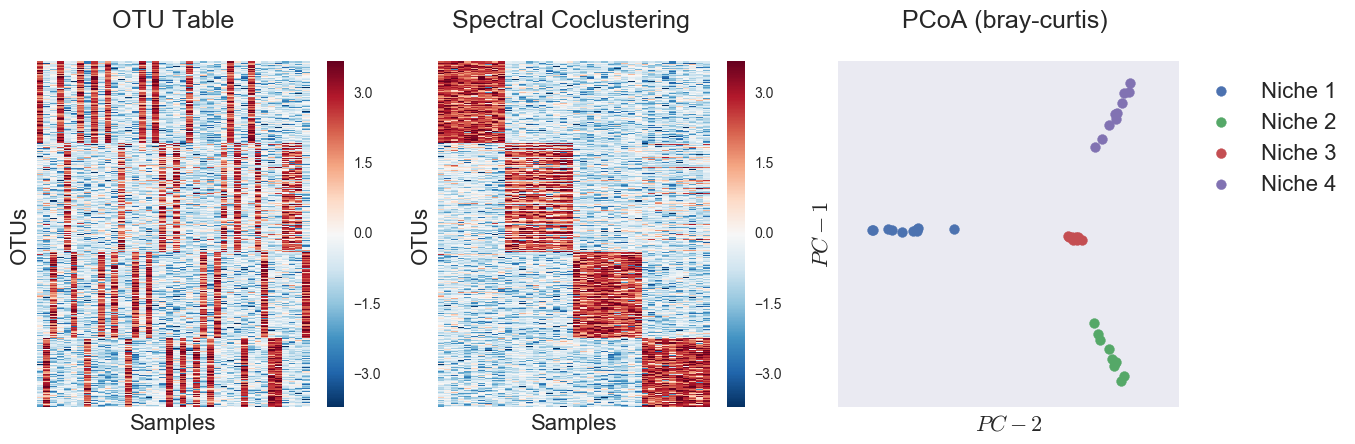

In [64]:
#show ground truth
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(3, 3)) 
sns.heatmap(clr(X_true+1),xticklabels=False, yticklabels=False,ax=ax1)
ax1.set_title('Original OTU table')
#comparison
#orgigonal
plot_compare(add_noise(X_true,.01,.01,.02,4.9),X_noise_suffle,mapping.T,'example',4)
#completed
plot_compare(add_noise(X_true,.01,.01,.02,4.9),reconstuctdf,mapping.T,'example',4)

In conclusion, matrix completion and biclustering are a powerful approach at analyzing the community structure of a population. 

 [Next Example](https://github.com/cjm007/DEICODE/blob/master/Examples/sponge_biom.ipynb)